## Imports

Run the imports block below:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from deepracer.tracks import TrackIO, Track
from deepracer.tracks.track_utils import track_breakdown
from deepracer.logs import CloudWatchLogs as cw, \
    SimulationLogsIO as slio, \
    NewRewardUtils as nr, \
    AnalysisUtils as au, \
    PlottingUtils as pu, \
    ActionBreakdownUtils as abu

# Ignore deprecation warnings we have no power over
import warnings
warnings.filterwarnings('ignore')

In [2]:
tu = TrackIO()
for f in tu.get_tracks():
    print(f)

AWS_track.npy
AmericasGeneratedInclStart.npy
Bowtie_track.npy
Canada_Eval.npy
Canada_Training.npy
China_eval_track.npy
China_track.npy
FS_June2020.npy
H_track.npy
LGSWide.npy
London_Loop_Train.npy
Mexico_track.npy
Mexico_track_eval.npy
New_York_Eval_Track.npy
New_York_Track.npy
Oval_track.npy
Spain_track.npy
Straight_track.npy
Tokyo_Training_track.npy
Vegas_track.npy
Virtual_May19_Train_track.npy
reInvent2019_track.npy
reInvent2019_wide.npy
reInvent2019_wide_mirrored.npy
reinvent_base.npy


Loaded 155 waypoints


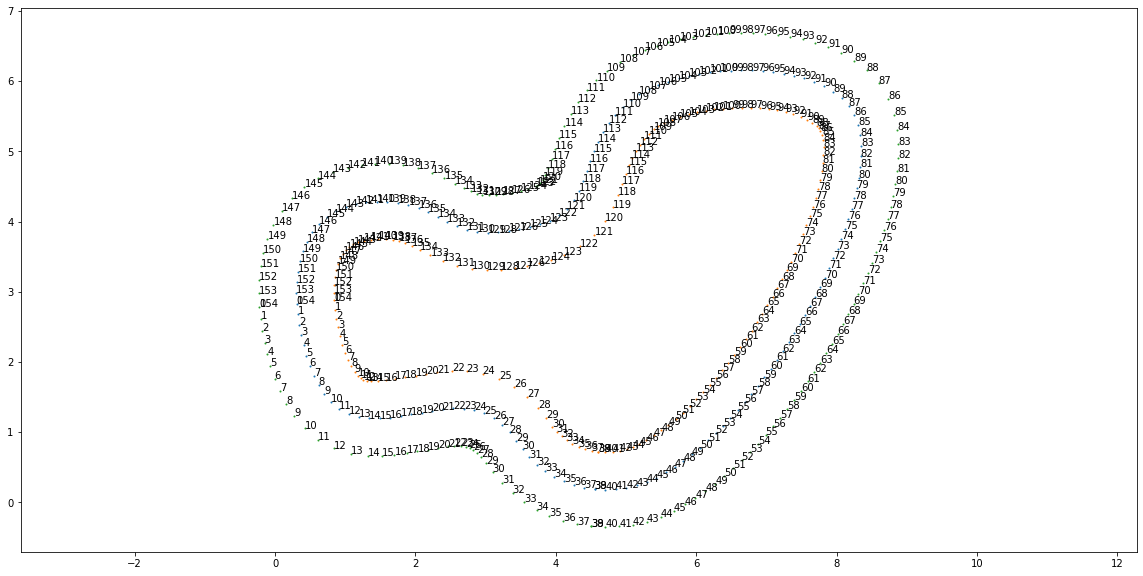

In [3]:
track: Track = tu.load_track("reInvent2019_track")

pu.plot_trackpoints(track)

In [5]:
# AWS DeepRacer Console Logs
stream_name = 'cloud-rl_coach_1174_1592874803492' ## CHANGE This to your simulation application ID
fname = 'logs/deepracer-%s.log' %stream_name  # The log will be downloaded into the specified path
cw.download_log(fname, stream_prefix=stream_name)  # add force=True if you downloaded the file before but want to repeat

Log file exists, use force=True to download again


## Load the trace training log

One important information to enter is the setting of your Episodes per iteration hyperparameter. This is used to group the episodes into iterations. This information is valuable when later looking at graphs showing how the training progresses per iteration. You can use it to detect which iteration gave you better outcomes and, if in local training, you could move to that iteration's outcome for submissions in the AWS DeepRacer League or  for continuing the training.

The log files you have just gathered above have lines like this one:
```
SIM_TRACE_LOG:799,111,1.7594,4.4353,3.0875,-0.26,2.50,2,1.0000,False,True,71.5802,49,17.67,1555554451.1110387
```
This is all that matters for us. The first two are some tests I believe and when loading they get skipped, then each next line has the following fields:
* episode number
* step number
* x coordinate
* y coordinate
* yaw of the car (where the car is heading)
* decision about turning (turn value from your action space)
* decision about throttle (speed value from your action space)
* decision index (value from your action space)
* reward value
* is the lap complete
* are all wheels on track?
* progress in the lap
* closest waypoint
* track length
* timestamp

`slio.load_data` and then `slio.convert_to_pandas` read it and prepare for your usage. Sorting the values may not be needed, but I have experienced under some circumstances that the log lines were not ordered properly.

In [6]:
EPISODES_PER_ITERATION = 20 #  Set to value of your hyperparameter in training

data = slio.load_data(fname)
df = slio.convert_to_pandas(data, episodes_per_iteration=EPISODES_PER_ITERATION)

df = df.sort_values(['episode', 'steps'])
# personally I think normalizing can mask too high rewards so I am commenting it out,
# but you might want it.
# slio.normalize_rewards(df)

#Uncomment the line of code below to evaluate a different reward function
#nr.new_reward(df, track.center_line, 'reward.reward_sample') #, verbose=True)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
iteration,144167.0,64.617693,25.842669,1.0000,47.00000,67.0000,87.00000,103.0000
episode,144167.0,1281.887915,516.932753,0.0000,926.00000,1336.0000,1721.00000,2052.0000
steps,144167.0,58.980370,49.943605,1.0000,18.00000,44.0000,89.00000,225.0000
x,144167.0,4.737273,2.526888,-0.5514,2.60970,4.8712,7.11545,9.1374
y,144167.0,3.377911,1.905364,-0.6851,1.49385,3.7793,5.03205,6.9068
yaw,144167.0,-9.940278,109.355552,-179.9969,-121.87725,-4.4012,70.69700,179.9994
steer,144167.0,4.499920,15.622657,-25.0000,0.00000,0.0000,20.00000,25.0000
throttle,144167.0,1.837180,0.767907,1.1000,1.10000,1.5000,2.10000,3.7000
action,144167.0,4.145775,2.319015,0.0000,3.00000,3.0000,6.00000,8.0000
reward,144167.0,2.407937,1.916883,0.0010,0.74605,2.0591,3.67625,7.8273


In [7]:
len(df)

144167

# Graphs of Training Progress

new reward not found, using reward as its values
Number of episodes =  2052
Number of iterations =  103


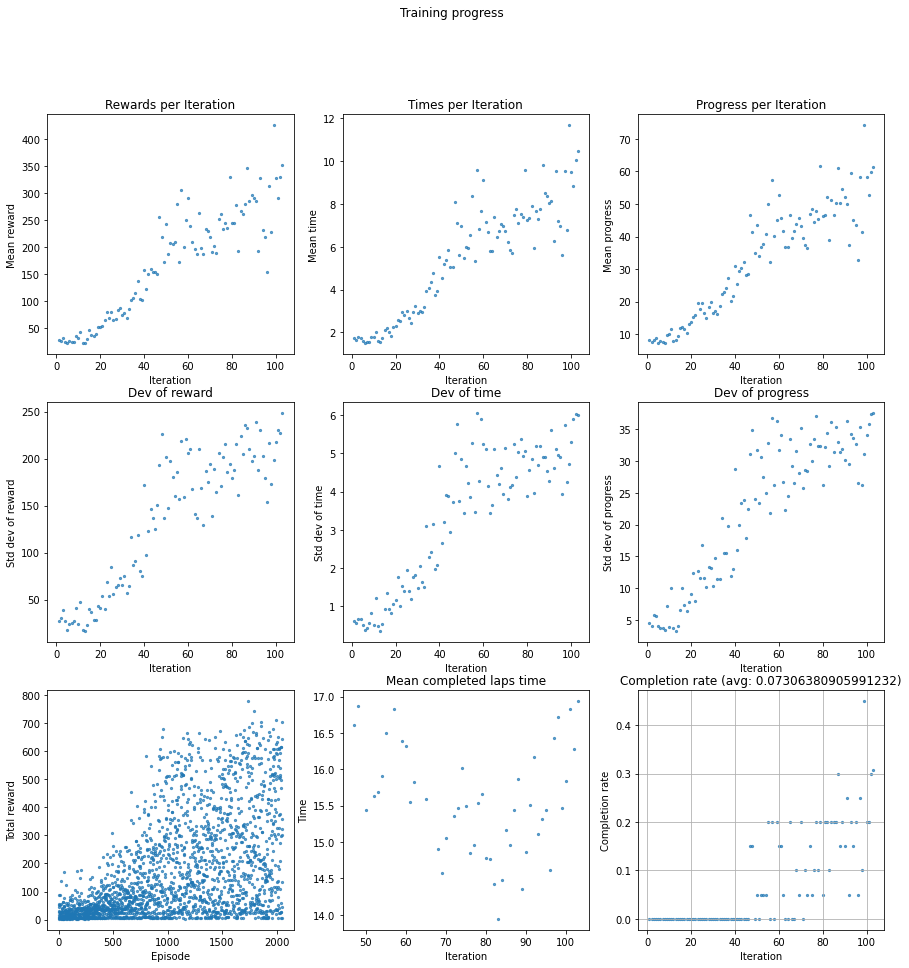

<Figure size 432x288 with 0 Axes>

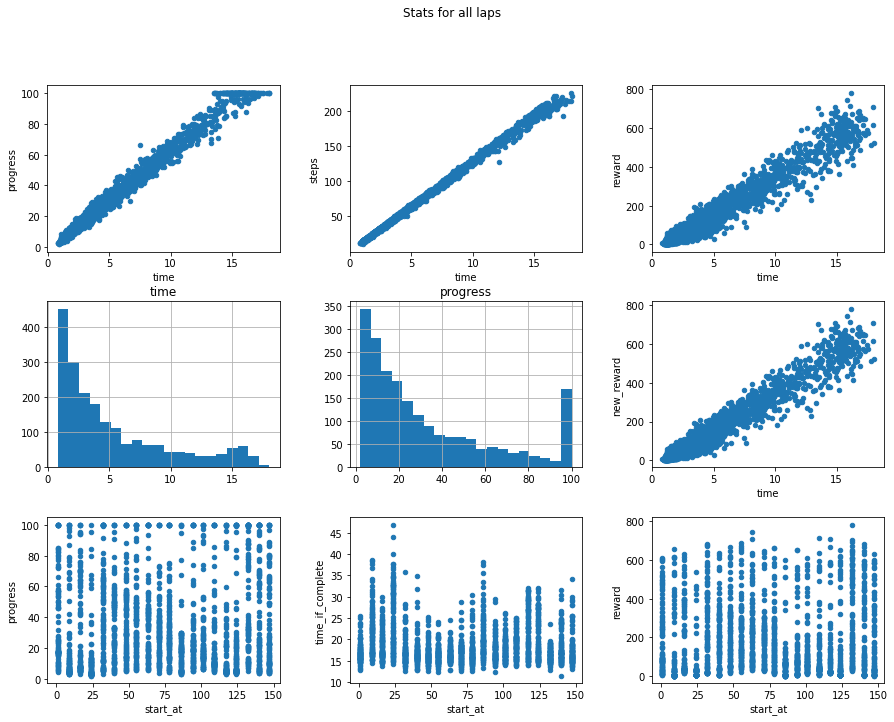

Number of episodes =  2049
Number of iterations =  103


<Figure size 432x288 with 0 Axes>

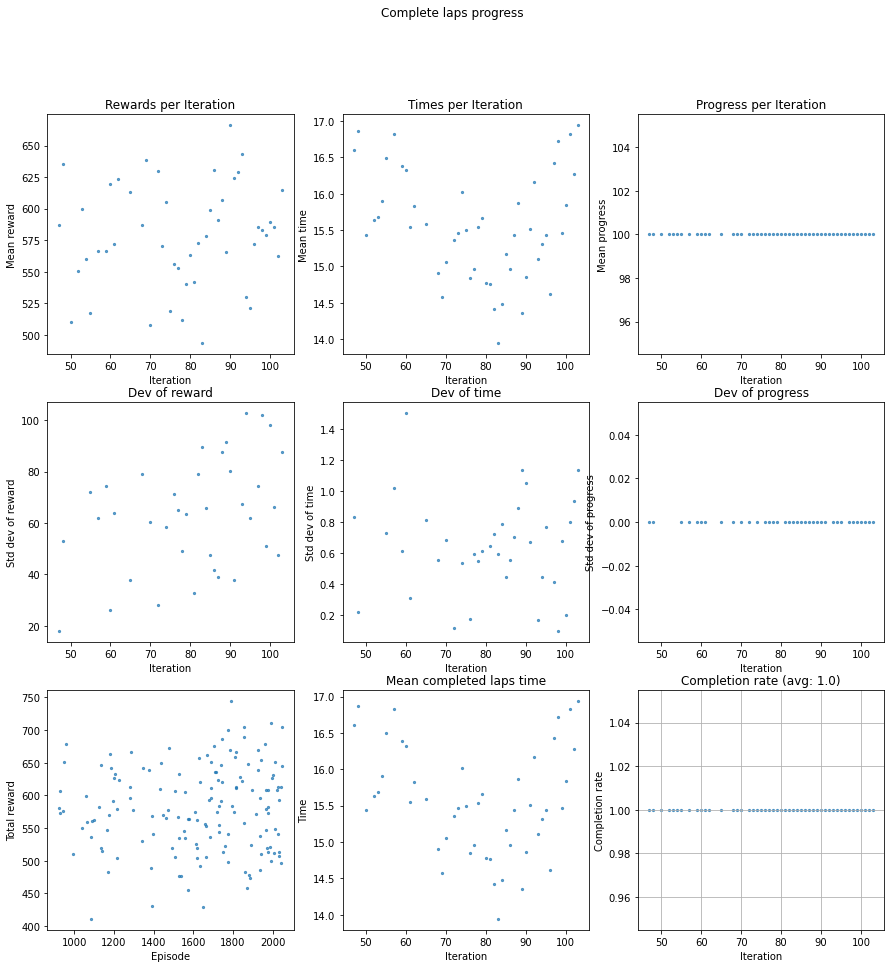

<Figure size 432x288 with 0 Axes>

In [8]:
simulation_agg = au.simulation_agg(df)
au.analyze_training_progress(simulation_agg, title='Training progress')
# ### Stats for all laps
au.scatter_aggregates(simulation_agg, 'Stats for all laps')
# ### Stats for complete laps
complete_ones = simulation_agg[simulation_agg['progress']==100]
au.analyze_training_progress(complete_ones, title='Complete laps progress')

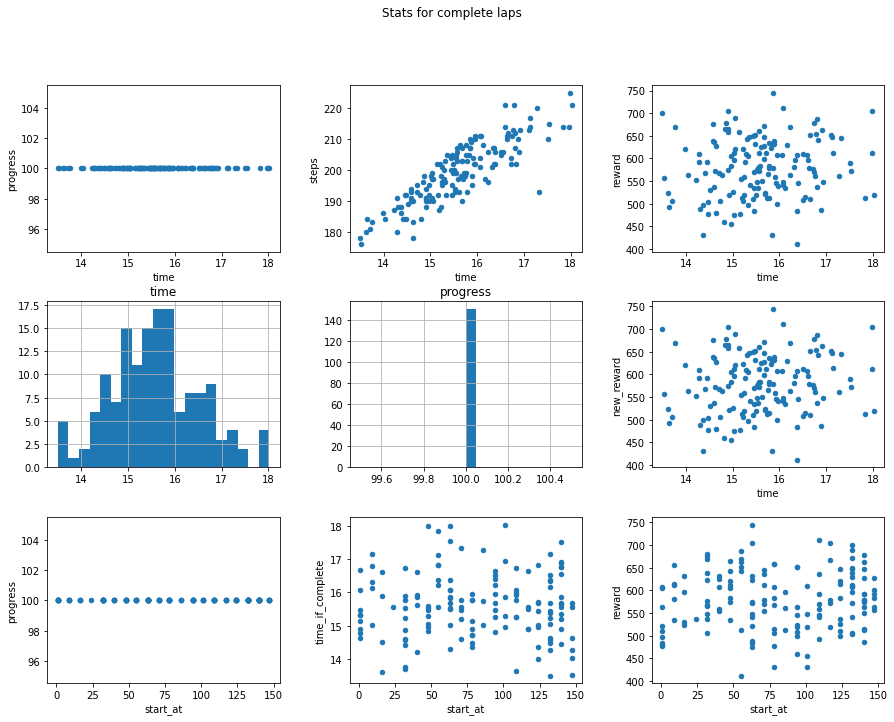

<Figure size 432x288 with 0 Axes>

In [9]:
complete_ones = simulation_agg[simulation_agg['progress']==100]

if complete_ones.shape[0] > 0:
    au.scatter_aggregates(complete_ones, 'Stats for complete laps')
else:
    print('No complete laps yet.')

### Iteration progress viewer

In [10]:
import numpy as np
simulation_agg.groupby('iteration')['progress'].mean()

iteration
1       8.088835
2       7.565065
3       8.317290
4       8.769060
5       7.187905
         ...    
99     74.187685
100    58.197510
101    52.689225
102    59.760160
103    61.238215
Name: progress, Length: 103, dtype: float64

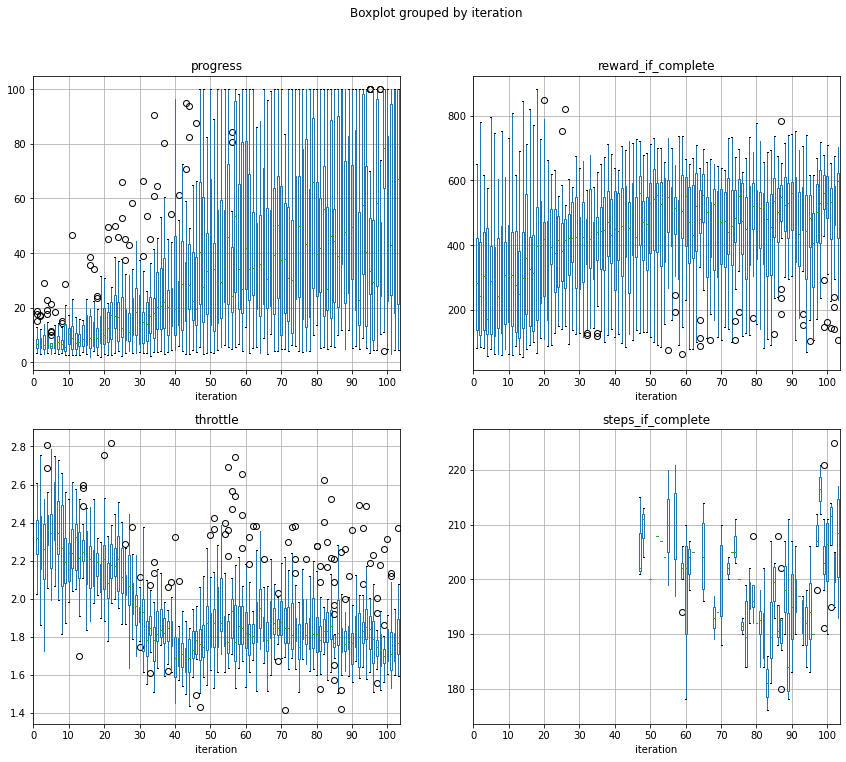

In [11]:
import numpy as np
fig, ax = plt.subplots(2, 2, figsize=(14, 12))
df_agg = simulation_agg[['iteration','progress','reward_if_complete','steps','throttle']]
df_agg = df_agg.drop('steps',axis=1)
df_agg['steps_if_complete'] = simulation_agg[simulation_agg['complete']==1]['steps']
#df_agg = df_agg.iloc[0:500]
for c in range(len(df_agg.columns))[1:]:
    df_agg.boxplot(column = df_agg.columns[c], by='iteration', ax=ax.flatten()[c-1])
    ax.flatten()[c-1].set_xticks(range(0,df_agg['iteration'].max(),10))
    ax.flatten()[c-1].set_xticklabels(range(0,df_agg['iteration'].max(),10))
    if c == 1 and df_agg['reward_if_complete'].max()>5*df_agg['reward_if_complete'].mean():
        ax.flatten()[c].set_ylim(top = df_agg['reward_if_complete'].mean()*3)
        if any(df_agg['reward_if_complete']<0):
            if df_agg['reward_if_complete'].min()<-5*df_agg['reward_if_complete'].mean():
                ax.flatten()[c].set_ylim(bottom = -df_agg['reward_if_complete'].mean()*1)
            else:
                ax.flatten()[c].set_ylim(bottom = 0)
#     elif c == 3 and df_agg['steps_if_complete'].max()>300:
#         ax.flatten()[c].set_ylim(bottom = 0, top = df_agg['steps_if_complete'].mean()*2.5)

### Categories analysis
We're going back to comparing training results based on the training time, but in a different way. Instead of just scattering things in relation to iteration or episode number, this time we're grouping episodes based on a certaing information. For this we use function:
```
analyze_categories(panda, category='quintile', groupcount=5, title=None)
```
The idea is pretty simple - determine a way to cluster the data and provide that as the `category` parameter (alongside the count of groups available). In the default case we take advantage of the aggregated information to which quintile an episode belongs and thus build buckets each containing 20% of episodes which happened around the same time during the training. If your training lasted for five hours, this would show results grouped per each hour.

A side note: if you run the function with `category='start_at'` and `groupcount=20` you will get results based on the waypoint closest to the starting point of an episode. If you need to, you can introduce other types of categories and reuse the function.

The graphs are similar to what we've seen above. I especially like the progress one which shows where the model tends to struggle and whether it's successful laps rate is improving or beginning to decrease. Interestingly, I also had cases where I saw the completion drop on the progress rate only to improve in a later quintile, but with a better time graph.

A second side note: if you run this function for `complete_ones` instead of `simulation_agg`, suddenly the time histogram becomes more interesting as you can see whether completion times improve.

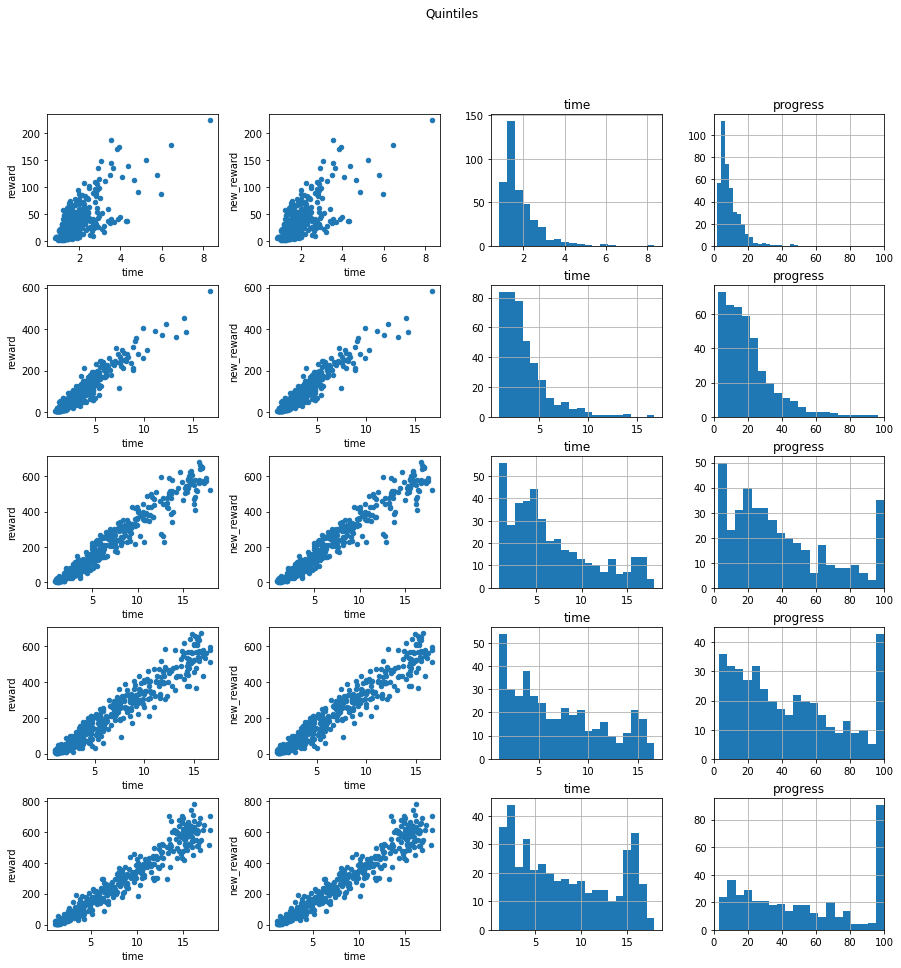

<Figure size 432x288 with 0 Axes>

In [12]:
au.scatter_by_groups(simulation_agg, title='Quintiles')

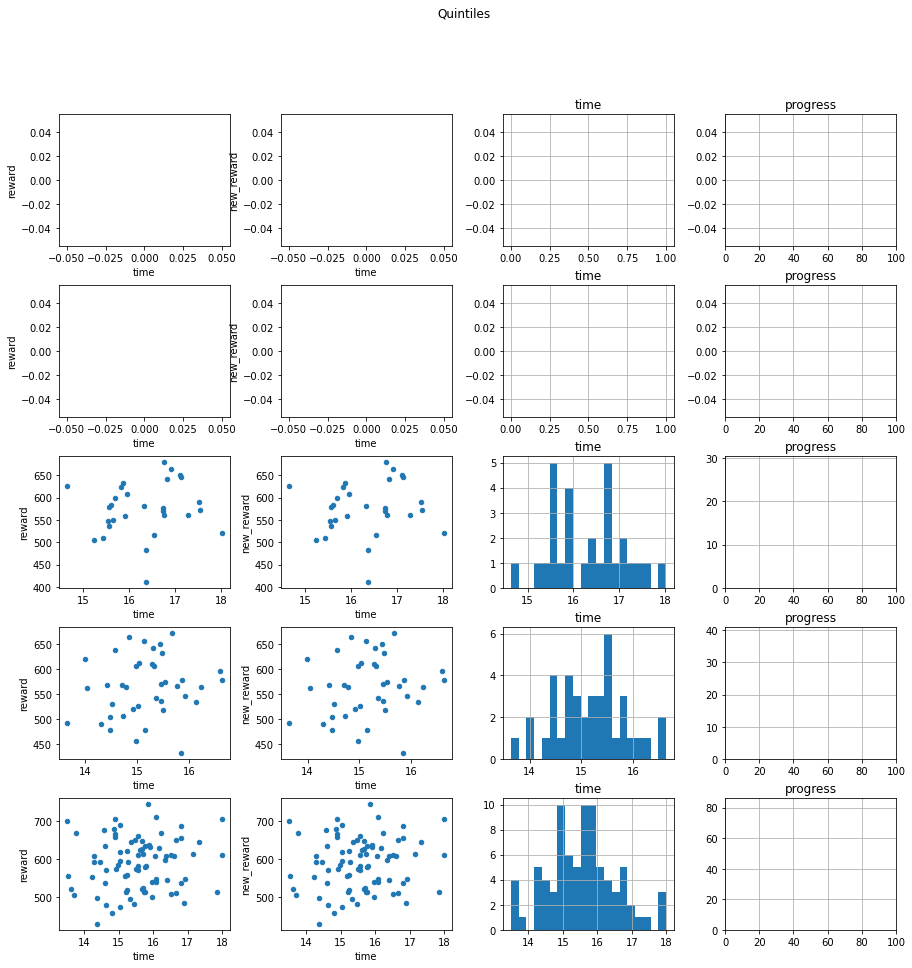

<Figure size 432x288 with 0 Axes>

In [13]:
au.scatter_by_groups(complete_ones, title='Quintiles')

## Data in tables

While a lot can be seen in graphs that cannot be seen in the raw numbers, the numbers let us get into more detail. Below you will find a couple examples. If your model is behaving the way you would like it to, below tables may provide little added value, but if you struggle to improve your car's performance, they may come handy. In such cases I look for examples where high reward is giving to below-expected episode and when good episodes are given low reward.

You can then take the episode number and scatter it below, and also look at reward given per step - this can in turn draw your attention to some rewarding anomalies and help you detect some unexpected outcomes in your reward function.

There is a number of ways to select the data for display:
* `nlargest`/`nsmallest` lets you display information based on a specific value being highest or lowest
* filtering based on a field value, for instance `df[df['episode']==10]` will display only those steps in `df` which belong to episode 10
* `head()` lets you peek into a dataframe

There isn't a right set of tables to display here and the ones below may not suit your needs. Get to know Pandas more and have fun with them. It's almost as addictive as DeepRacer itself.

The examples have a short comment next to them explaining what they are showing.

In [14]:
# View ten best rewarded episodes in the training
simulation_agg.nlargest(10, 'reward').T

,1737,1788,1994,1855,2048,1777,1857,1747,1964,958
iteration,87,90,100,93,103,89,93,88,99,48
episode,1737,1788,1994,1855,2048,1777,1857,1747,1964,958
steps,200,207,211,191,214,178,197,207,198,211
start_at,132,63,109,117,63,132,132,55,32,140
progress,99.4373,100,100,100,100,100,100,100,100,100
time,16.1618,15.8541,16.0684,14.8989,17.9778,13.4961,15.0503,16.8138,14.8626,16.7492
new_reward,778.901,744.574,711.027,705.313,705.03,700.526,688.728,686.838,679.189,679.061
throttle,1.709,1.65749,1.60332,1.84241,1.67383,1.75506,1.65635,1.75797,1.63939,1.59005
reward,778.901,744.574,711.027,705.313,705.03,700.526,688.728,686.838,679.189,679.061
time_if_complete,16.2532,15.8541,16.0684,14.8989,17.9778,13.4961,15.0503,16.8138,14.8626,16.7492


In [15]:
# View five fastest complete laps
print('Total number of episodes ',max(simulation_agg['episode']))
complete_ones.nsmallest(10, 'time').T

Total number of episodes  2052


,1777,1659,1762,1634,1664,1784,1636,1619,1665,1977
iteration,89,83,89,82,84,90,82,81,84,99
episode,1777,1659,1762,1634,1664,1784,1636,1619,1665,1977
steps,178,176,180,184,181,183,186,184,187,191
start_at,132,147,16,109,32,32,124,147,40,132
progress,100,100,100,100,100,100,100,100,100,100
time,13.4961,13.5251,13.6119,13.6374,13.7042,13.7557,13.9891,14.0387,14.2177,14.2789
new_reward,700.526,556.475,522.808,491.982,506.096,669.713,620.395,562.46,553.238,608.934
throttle,1.75506,1.82841,1.83444,1.80109,1.86133,1.76011,1.80108,1.85652,1.81016,1.69476
reward,700.526,556.475,522.808,491.982,506.096,669.713,620.395,562.46,553.238,608.934
time_if_complete,13.4961,13.5251,13.6119,13.6374,13.7042,13.7557,13.9891,14.0387,14.2177,14.2789


In [16]:
# View five best rewarded completed laps
complete_ones.nlargest(10, 'reward').T

,1788,1994,1855,2048,1777,1857,1747,1964,958,1704
iteration,90,100,93,103,89,93,88,99,48,86
episode,1788,1994,1855,2048,1777,1857,1747,1964,958,1704
steps,207,211,191,214,178,197,207,198,211,191
start_at,63,109,117,63,132,132,55,32,140,32
progress,100,100,100,100,100,100,100,100,100,100
time,15.8541,16.0684,14.8989,17.9778,13.4961,15.0503,16.8138,14.8626,16.7492,14.5853
new_reward,744.574,711.027,705.313,705.03,700.526,688.728,686.838,679.189,679.061,675.706
throttle,1.65749,1.60332,1.84241,1.67383,1.75506,1.65635,1.75797,1.63939,1.59005,1.80681
reward,744.574,711.027,705.313,705.03,700.526,688.728,686.838,679.189,679.061,675.706
time_if_complete,15.8541,16.0684,14.8989,17.9778,13.4961,15.0503,16.8138,14.8626,16.7492,14.5853


### Path taken and throttle values in a particular episode

Lap time: 13.50


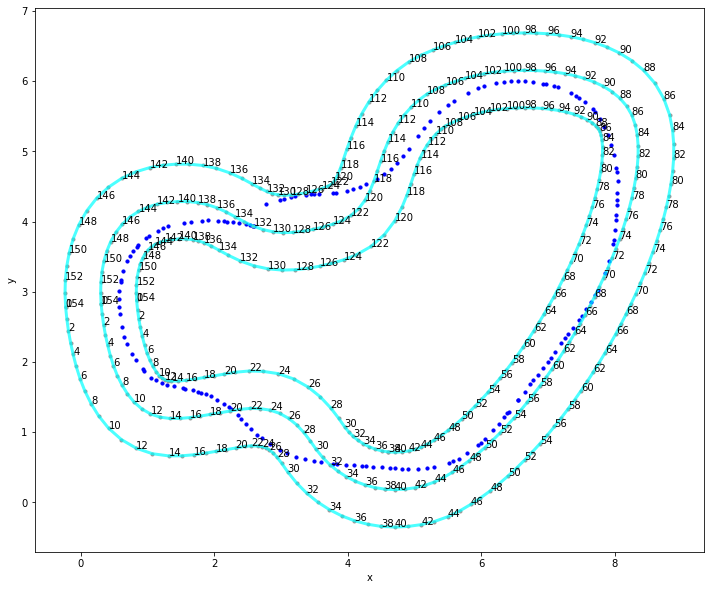

<Figure size 432x288 with 0 Axes>

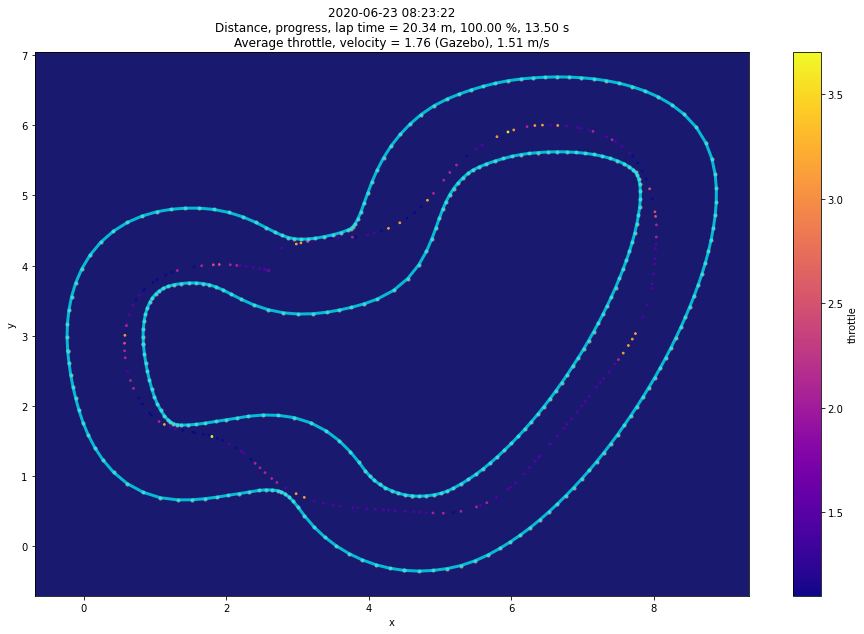

<Figure size 432x288 with 0 Axes>

In [18]:
episode_id = 1777
print('Lap time: ' "{:0.2f}".format(float(simulation_agg[simulation_agg['episode']==episode_id]['time'])))
pu.plot_selected_laps(simulation_agg[simulation_agg['episode'] == episode_id], df, track)
pu.plot_grid_world(df[df['episode']==episode_id], track)

Lap time: 15.85


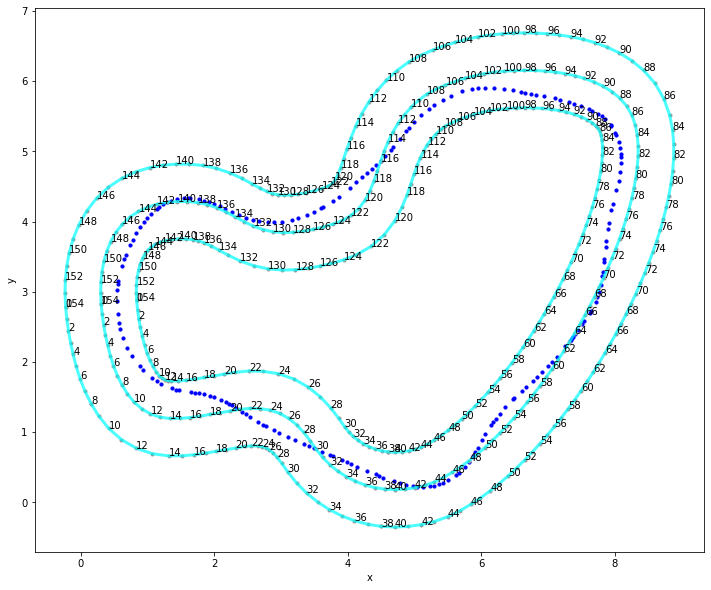

<Figure size 432x288 with 0 Axes>

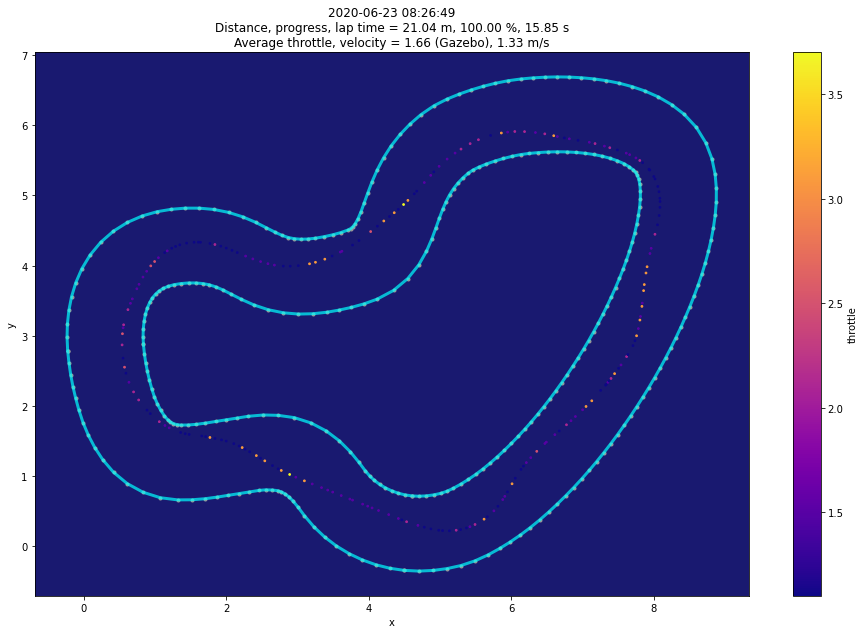

<Figure size 432x288 with 0 Axes>

In [19]:
episode_id = 1788
print('Lap time: ' "{:0.2f}".format(float(simulation_agg[simulation_agg['episode']==episode_id]['time'])))
pu.plot_selected_laps(simulation_agg[simulation_agg['episode'] == episode_id], df, track)
pu.plot_grid_world(df[df['episode']==episode_id], track)

## Analyze the reward distribution for your reward function

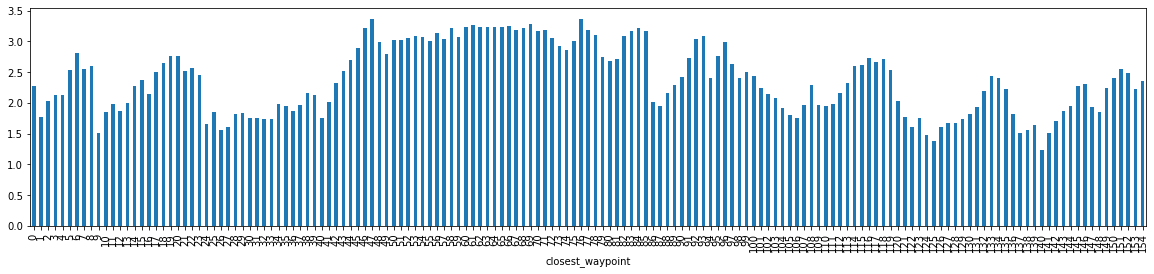

In [20]:
# This shows a histogram of actions per closest waypoint for episode 771.
# Will let you spot potentially problematic places in reward granting.
# In this example reward function is clearly `return 1`. It may be worrying
# if your reward function has some logic in it.
# If you have a final step reward that makes the rest of this histogram
# unreadable, you can filter the last step out by using
# `episode[:-1].plot.bar` instead of `episode.plot.bar`
#episode = df[df['episode']==118]
episode = df.groupby('closest_waypoint').mean()['reward']
episode.plot.bar(x='closest_waypoint', y='reward')
fig = plt.gcf()
fig.set_size_inches(20,4)

# out = pd.cut(s, bins=[0, 0.35, 0.7, 1], include_lowest=True)
# ax = out.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(6,4))
# ax.set_xticklabels([c[1:-1].replace(","," to") for c in out.cat.categories])
# plt.show()

### Path taken for top reward iterations

NOTE: at some point in the past in a single episode the car could go around multiple laps, the episode was terminated when car completed 1000 steps. Currently one episode has at most one lap. This explains why you can see multiple laps in an episode plotted below.

Being able to plot the car's route in an episode can help you detect certain patterns in its behaviours and either promote them more or train away from them. While being able to watch the car go in the training gives some information, being able to reproduce it after the training is much more practical.

Graphs below give you a chance to look deeper into your car's behaviour on track.

We start with plot_selected_laps. The general idea of this block is as follows:
* Select laps(episodes) that have the properties that you care about, for instance, fastest, most progressed, failing in a certain section of the track or not failing in there,
* Provide the list of them in a dataframe into the plot_selected_laps, together with the whole training dataframe and the track info,
* You've got the laps to analyse.

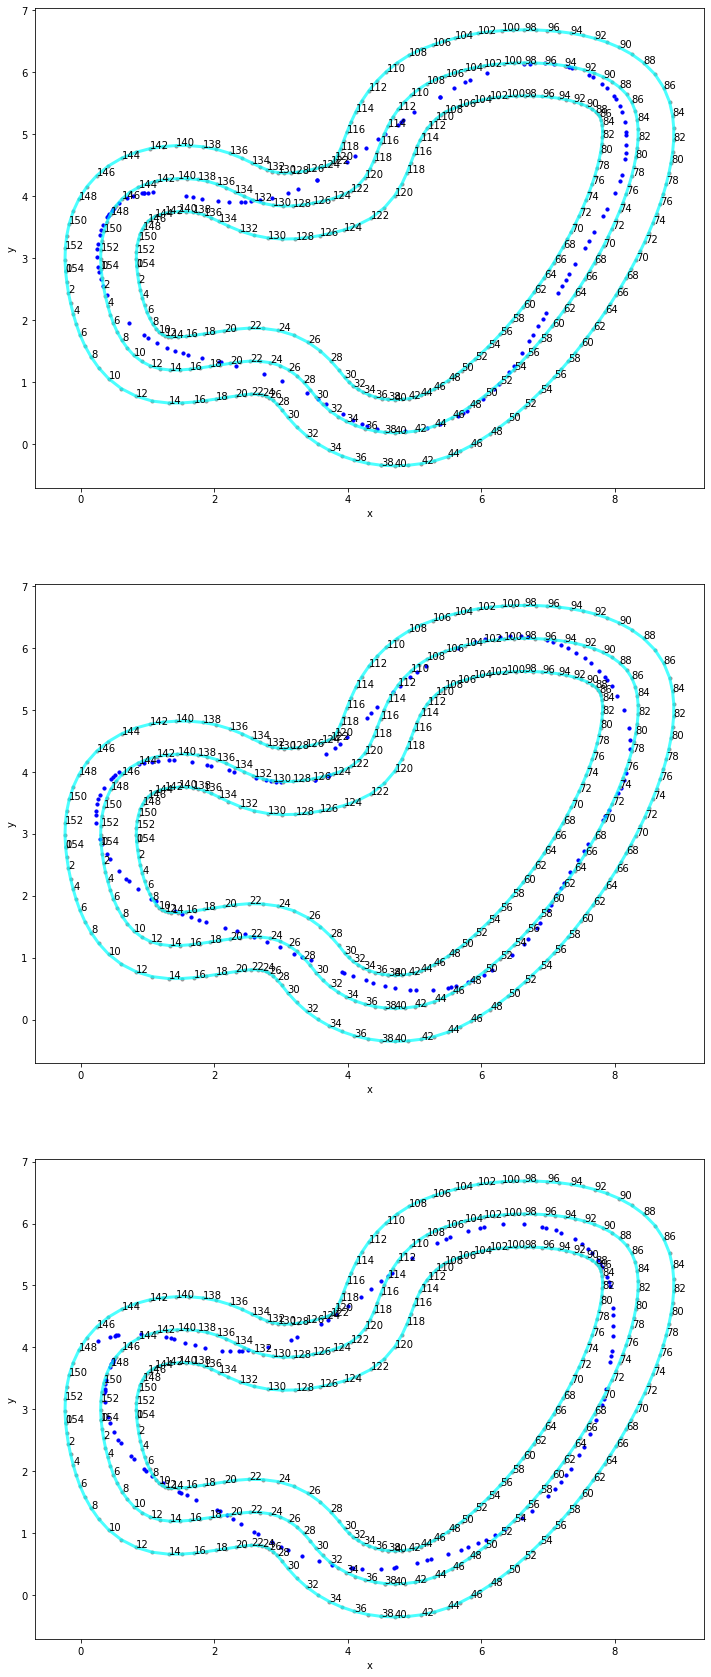

<Figure size 432x288 with 0 Axes>

In [20]:
# Some examples:
# highest reward for complete laps:
# episodes_to_plot = complete_ones.nlargest(3,'reward')

# fastest run for completed laps:
episodes_to_plot = complete_ones.nsmallest(3, 'time')

pu.plot_selected_laps(episodes_to_plot, df, track)

### Plot a heatmap of rewards for current training. 

In [129]:
#df[df['throttle']==3]

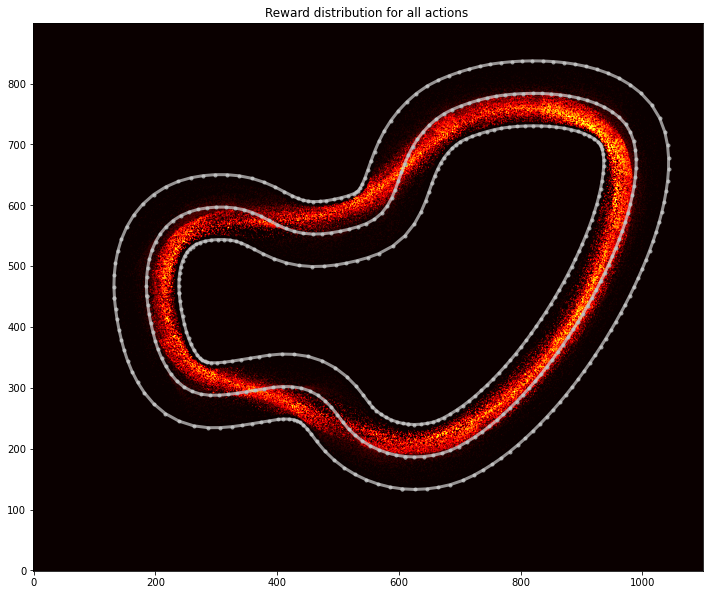

<Figure size 432x288 with 0 Axes>

In [21]:
#If you'd like some other colour criterion, you can add
#a value_field parameter and specify a different column
#pu.plot_track(df[df['iteration']>80], track)
pu.plot_track(df, track)

### Plot a particular iteration
This is same as the heatmap above, but just for a single iteration.

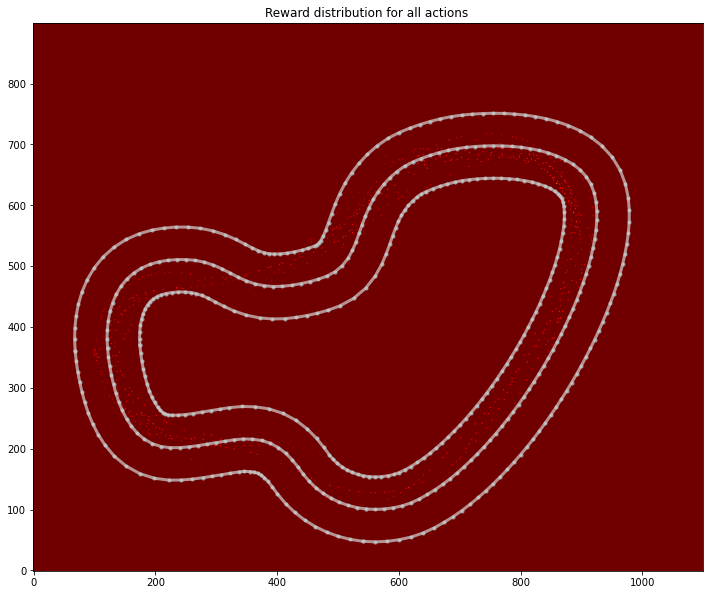

<Figure size 432x288 with 0 Axes>

In [23]:
#If you'd like some other colour criterion, you can add
#a value_field parameter and specify a different column
iteration_id = 30

pu.plot_track(df[df['iteration'] == iteration_id], track)

### Path taken in a particular iteration

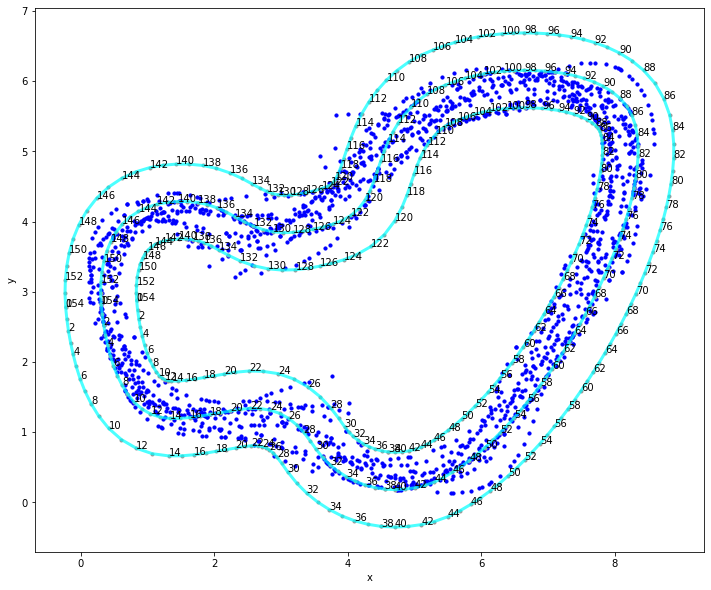

<Figure size 432x288 with 0 Axes>

In [25]:
iteration_id = 100

pu.plot_selected_laps([iteration_id], df, track, section_to_plot = 'iteration')

### Generate Racing Line

In [133]:
#Copy of Brensenham line algorithm and Shapely to determine racing line
#Breaks down in complex tracks as it hits inner border and stops
#Needs fixing

# data = slio.load_data(fname)
# df = slio.convert_to_pandas(data, episodes_per_iteration=EPISODES_PER_ITERATION)

# from shapely.geometry.polygon import LineString
# from shapely.geometry.polygon import Polygon
# from shapely.geometry import Point
# import math

# def br(x0, y0, x1, y1):
# #     Yield integer coordinates on the line from (x0, y0) to (x1, y1).

# #     Input coordinates should be integers.

# #     The result will contain both the start and the end point.

#     dx = x1 - x0
#     dy = y1 - y0

#     xsign = 1 if dx > 0 else -1
#     ysign = 1 if dy > 0 else -1

#     dx = abs(dx)
#     dy = abs(dy)

#     if dx > dy:
#         xx, xy, yx, yy = xsign, 0, 0, ysign
#     else:
#         dx, dy = dy, dx
#         xx, xy, yx, yy = 0, ysign, xsign, 0

#     D = 2*dy - dx
#     y = 0

#     for x in range(dx + 1):
#         yield x0 + x*xx + y*yx, y0 + x*xy + y*yy
#         if D >= 0:
#             y += 1
#             D -= 2*dx
#         D += 2*dy

# def get_vector_length(v):
#     return (v[0] ** 2 + v[1] ** 2) ** 0.5

# def vector(a, b):
#     return b[0] - a[0], b[1] - a[1]

# def plot_perfect_line(df, l_center_line, inner_border, outer_border):
    
#     l_center_line = l_center_line*100
#     inner_border = inner_border*100
#     outer_border = outer_border*100
#     df[['x','y']] = df[['x','y']]*100
    
#     road_poly2 = Polygon(np.vstack((outer_border, np.flipud(inner_border))))
    
#     fig = plt.figure(1, figsize=(12, 18))
#     ax = fig.add_subplot(211)
    
#     line = LineString(l_center_line)
#     pu._plot_coords(ax, line)
#     pu._plot_line(ax, line)
#     pu.plot_points(ax, l_center_line, 2)
    
#     line = LineString(inner_border)
#     pu._plot_coords(ax, line)
#     pu._plot_line(ax, line)
#     pu.plot_points(ax, inner_border, 2)
    
#     line = LineString(outer_border)
#     pu._plot_coords(ax, line)
#     pu._plot_line(ax, line)
#     pu.plot_points(ax, outer_border, 2)
    
    
#     x0 = df[df['episode'] == 0]['x'].iloc[0]
#     y0 = df[df['episode'] == 0]['y'].iloc[0]
#     params = nr.df_to_params(df[df['episode'] == 0].iloc[0], l_center_line)
#     h = params['heading']
#     x1 = x0
#     y1 = y0
#     X = [x0]
#     Y = [y0]
#     for iii in range(100):
#         plists = [None] * 9
#         llists = [None] * 9
#         for i in range(9):
#             plists[i] = list(br(int(x1), int(y1),
#                                 int(x1 + 7000 * math.cos(math.radians(h - 20 + (i*40.0)/8.0))),
#                                 int(y1 + 7000 * math.sin(math.radians(h - 20 + (i*(40.0/8.0)))))))
#             for j in range(len(plists[i])):
#                 if not road_poly2.contains(Point(plists[i][j][0], plists[i][j][1])):
#                     plists[i] = plists[i][:j]
#                     break
#             if len(plists[i]) > 0: #== 1427:
#                 #parr = np.array(plists[i])
#                 #plt.plot(parr[:, 0], parr[:, 1])
#                 llists[i] = get_vector_length(vector(plists[i][0], plists[i][len(plists[i]) - 1]))
#             else:
#                 llists[i] = 0
#         l = llists.index(max(llists))
#         #print(l)
#         if len(plists[l]) <= 0:
#             break
#         x1 = plists[l][0][0]
#         y1 = plists[l][0][1]
#         x2 = plists[l][len(plists[l]) - 1][0]
#         y2 = plists[l][len(plists[l]) - 1][1]

#         right_heading = math.atan2(y2 - y1, x2 - x1)
#         #h = math.degrees(right_heading)
#         h += (l-4) * 30 * 0.5 
#         x1 += 25*math.cos(right_heading)
#         y1 += 25*math.sin(right_heading)
#         X.append(x1)
#         Y.append(y1)

#     plt.plot(X, Y, 'r.')

    
# plot_perfect_line(df, track.center_line, track.inner_border, track.outer_border)